### Autoencoder theory

An autoencoder is an artificial neural network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Recently, the autoencoder concept has become more widely used for learning generative models of data.

Architecturally, the simplest form of an autoencoder is a feedforward, non-recurrent neural network very similar to the multilayer perceptron (MLP) – having an input layer, an output layer, and one or more hidden layers connecting them, but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs (instead of predicting the target value _Y_ given inputs _X_. Therefore, autoencoders are unsupervised learning models.

Our basic representation of an autoencoder with one hidden layer can be expressed as:

\begin{align}
\ Z = s(X.dot(W_h)+b_h)
\end{align}

\begin{align}
\ X_{hat} = s(Z.dot(W_o)+b_o)
\end{align}

However, a common modification that we make in order to simplify the equation and introduce a degree of regularization is to use the transpose of $W_h$ on the output layer. This is known as using _shared weights_.

\begin{align}
\ Z = s(X.dot(W)+b_h)
\end{align}

\begin{align}
\ X_{hat} = s(Z.dot(W^T)+b_o)
\end{align}

The objective function in autoencoders is: 

\begin{align}
\ J = \mid X - X_{hat} \mid_F^2 = \mid X - s(s(XW)W^T) \mid_F^2
\end{align}

As is _obvious_ from the equation above, autoencoders are like nonlinear PCA. The primary differences are: 
- bias
- requirement that column of W has length of 1
- orthogonality
- order


Denoising autoencoders add noise to our input in order to help our data get better at reconstruction the original input. The denoising auto-encoder is a stochastic version of the auto-encoder. In one variation, the stochastic corruption process randomly sets some of the inputs (as many as half of them) to zero. Hence the denoising auto-encoder is trying to predict the corrupted (i.e. missing) values from the uncorrupted (i.e., non-missing) values, for randomly selected subsets of missing patterns. Note how being able to predict any subset of variables from the rest is a sufficient condition for completely capturing the joint distribution between a set of variables (this is how Gibbs sampling works).

Stacked autoencoders work like this: 
- start with the input data X
- train an autoencoder on X; the hidden layer's output is $Z_1$
- train an autoencoder on $Z_1$ (target is $Z_1$); the hidden layer's output is $Z_2$
- repeat  

We want each layer to be a more compact representation than the last, so each layer will decrease in size. This is one way we can use stacked autoencoders for data compression. This is not a requirement, though, and even using as many hidden units as there are observations has been shown to not lead to overfitting.  

The process is know as _greedy layer-wise pretraining_. It means that we are making the best short-sighted decision, and it works well to use as a precursor to supervised learning. But the good news is that we don't have to do too many epochs of backpropagation, since the autoencoder does most of the work on this front. 

### Autoencoder in code

In [2]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import os
os.chdir('/home/z/Dropbox/Documents/Analytics/Learning/Data-Science-Curriculum/extras')
from util import relu, error_rate, getKaggleMNIST, init_weights

In [12]:
class AutoEncoder(object):
    # M is an arbitrary parameter
    # ID is used for setting names of theano variables
    def __init__(self, M, an_id):
        self.M = M
        self.id = an_id

    # we will include momentum in our autoencoder'
    # no Y - unsupervised
    def fit(self, X, learning_rate=0.5, mu=0.99, epochs=1, batch_sz=100, show_fig=False):
        N, D = X.shape
        # get number of batches
        n_batches = N / batch_sz

        #our weights will be D-by-M
        W0 = init_weights((D, self.M))

        # this is where we use the ID variable
        self.W = theano.shared(W0, 'W_%s' % self.id)
        self.bh = theano.shared(np.zeros(self.M), 'bh_%s' % self.id)
        self.bo = theano.shared(np.zeros(D), 'bo_%s' % self.id)
        
        # we will keep all of our parameters b/c we will use them during gradient descent
        self.params = [self.W, self.bh, self.bo]
        
        # we will keep the forward params for the deep NN class
        self.forward_params = [self.W, self.bh]

        # keep track of the changes of each variable because we will use momentum
        # TODO: technically these should be reset before doing backprop
        self.dW = theano.shared(np.zeros(W0.shape), 'dW_%s' % self.id)
        self.dbh = theano.shared(np.zeros(self.M), 'dbh_%s' % self.id)
        self.dbo = theano.shared(np.zeros(D), 'dbo_%s' % self.id)
        
        # similarly, collect the parameters here
        self.dparams = [self.dW, self.dbh, self.dbo]
        self.forward_dparams = [self.dW, self.dbh]

        # now we define the tensor input, which is a matrix
        X_in = T.matrix('X_%s' % self.id)
        
        # define x-hat, which is our reconstruction
        X_hat = self.forward_output(X_in)

        # attach it to the object so it can be used later
        # must be sigmoidal because the output is also a sigmoid
        # hidden layer operation will be defined as a theano function, since it will be used in the DNN
        H = T.nnet.sigmoid(X_in.dot(self.W) + self.bh)
        self.hidden_op = theano.function(
            inputs=[X_in],
            outputs=H,
        )

        # squared error cost function:
        # cost = ((X_in - X_hat) * (X_in - X_hat)).sum() / N
        
        # cross-entropy cost function:
        cost = -(X_in * T.log(X_hat) + (1 - X_in) * T.log(1 - X_hat)).sum() / (batch_sz * D)
        cost_op = theano.function(
            inputs=[X_in],
            outputs=cost,
        )

        # this is our gradient descent (where we define our updates)
        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        # here is our train function for the gradient descent
        train_op = theano.function(
            inputs=[X_in],
            updates=updates,
        )

        # now we run our loop through this
        costs = []
        print("training autoencoder: %s" % self.id)
        for i in range(epochs):
            print("epoch:", i)
            X = shuffle(X)
            for j in range(int(n_batches)):
                batch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(batch)
                the_cost = cost_op(X) # technically we could also get the cost for Xtest here
                if j == 408:
                    print("j / n_batches:", j, "/", n_batches, "cost:", the_cost)
                costs.append(the_cost)
        if show_fig:
            plt.plot(costs)
            plt.show()

    # this function will go to the hidden output, which takes in x
    def forward_hidden(self, X):
        Z = T.nnet.sigmoid(X.dot(self.W) + self.bh)
        # Z = T.tanh(X.dot(self.W) + self.bh)
        # Z = relu(X.dot(self.W) + self.bh)
        return Z

    # forward output will call the previous function and apply the sigmoid
    def forward_output(self, X):
        Z = self.forward_hidden(X)
        # we transpose W because we are doing shared weights
        Y = T.nnet.sigmoid(Z.dot(self.W.T) + self.bo)
        return Y

    @staticmethod
    def createFromArrays(W, bh, bo, an_id):
        ae = AutoEncoder(W.shape[1], an_id)
        ae.W = theano.shared(W, 'W_%s' % ae.id)
        ae.bh = theano.shared(bh, 'bh_%s' % ae.id)
        ae.bo = theano.shared(bo, 'bo_%s' % ae.id)
        ae.params = [ae.W, ae.bh, ae.bo]
        ae.forward_params = [ae.W, ae.bh]
        return ae

In [13]:
class DNN(object):
	# we will expand this later to accommodate RBMs as well
    def __init__(self, hidden_layer_sizes, UnsupervisedModel=AutoEncoder):
        self.hidden_layers = []
        count = 0
        # the count is the ID for each autoencoder
        for M in hidden_layer_sizes:
            ae = UnsupervisedModel(M, count)
            self.hidden_layers.append(ae)
            count += 1

    # this is supervised, so it includes Y.
    def fit(self, X, Y, Xtest, Ytest, pretrain=True, learning_rate=0.01, mu=0.99, reg=0.1, epochs=1, batch_sz=100):
        # greedy layer-wise training of autoencoders
        pretrain_epochs = 1
        if not pretrain:
            pretrain_epochs = 0

        # this is where we do our pretrain
        current_input = X
        for ae in self.hidden_layers:
            ae.fit(current_input, epochs=pretrain_epochs)

            # create current_input for the next layer
            current_input = ae.hidden_op(current_input)

        # initialize logistic regression layer
        N = len(Y)
        # K is the number of the classes
        K = len(set(Y))
        # the size of the weight is the last hidden layer's M, and then K
        W0 = init_weights((self.hidden_layers[-1].M, K))
        self.W = theano.shared(W0, "W_logreg")
        self.b = theano.shared(np.zeros(K), "b_logreg")

        # collect parameters for gradient descent
        self.params = [self.W, self.b]
        # pull in parameters from the previously collected lists
        for ae in self.hidden_layers:
            self.params += ae.forward_params

        # for momentum
        self.dW = theano.shared(np.zeros(W0.shape), "dW_logreg")
        self.db = theano.shared(np.zeros(K), "db_logreg")
        self.dparams = [self.dW, self.db]
        for ae in self.hidden_layers:
            self.dparams += ae.forward_dparams

        # define our inputs and our outputs
        X_in = T.matrix('X_in')
        targets = T.ivector('Targets')

        # probability of Y given X
        pY = self.forward(X_in)

        # define the regularization cost:
        # squared_magnitude = [(p*p).sum() for p in self.params]
        # reg_cost = T.sum(squared_magnitude)
        # previously we treated the targets as an indicator matrix and the output of a NN as a matrix of outputs
        # we will only select the elements of pY that we want, which is where the targets are 1
        cost = -T.mean( T.log(pY[T.arange(pY.shape[0]), targets]) ) #+ reg*reg_cost
        # need prediction function to calculate the error rate
        prediction = self.predict(X_in)
        cost_predict_op = theano.function(
            inputs=[X_in, targets],
            outputs=[cost, prediction],
        )

        updates = [
            (p, p + mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ] + [
            (dp, mu*dp - learning_rate*T.grad(cost, p)) for p, dp in zip(self.params, self.dparams)
        ]
        # updates = [(p, p - learning_rate*T.grad(cost, p)) for p in self.params]
        train_op = theano.function(
            inputs=[X_in, targets],
            updates=updates,
        )

        n_batches = N / batch_sz
        costs = []
        print("supervised training...")
        for i in range(epochs):
            print("epoch:", i)
            X, Y = shuffle(X, Y)
            for j in range(int(n_batches)):
                Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                train_op(Xbatch, Ybatch)
                the_cost, the_prediction = cost_predict_op(Xtest, Ytest)
                error = error_rate(the_prediction, Ytest)
                if j == 408:
                    print("j / n_batches:", j, "/", n_batches, "cost:", the_cost, "error:", error)
                costs.append(the_cost)
        plt.plot(costs)
        plt.show()

    def predict(self, X):
        return T.argmax(self.forward(X), axis=1)

    def forward(self, X):
        current_input = X
        for ae in self.hidden_layers:
            Z = ae.forward_hidden(current_input)
            current_input = Z

        # logistic layer
        Y = T.nnet.softmax(T.dot(current_input, self.W) + self.b)
        return Y

training autoencoder: 0
epoch: 0
j / n_batches: 408 / 410.0 cost: 50.61025039214906
training autoencoder: 1
epoch: 0
j / n_batches: 408 / 410.0 cost: 102.46950189031583
training autoencoder: 2
epoch: 0
j / n_batches: 408 / 410.0 cost: 57.48735243756561
supervised training...
epoch: 0
j / n_batches: 408 / 410.0 cost: 0.21723407616486926 error: 0.06
epoch: 1
j / n_batches: 408 / 410.0 cost: 0.15267308577146935 error: 0.041
epoch: 2
j / n_batches: 408 / 410.0 cost: 0.1293009091252335 error: 0.035


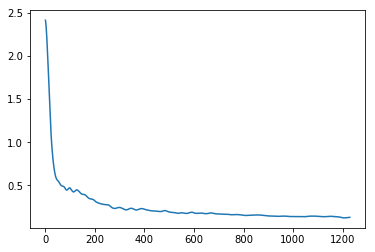

In [14]:
Xtrain, Ytrain, Xtest, Ytest = getKaggleMNIST()
dnn = DNN([1000, 750, 500])
dnn.fit(Xtrain, Ytrain, Xtest, Ytest, epochs=3)
# vs
#dnn = DNN([1000, 750, 500])
#dnn.fit(Xtrain, Ytrain, Xtest, Ytest, pretrain=False, epochs=10)